In [1]:
import pandas as pd
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

from data_utils import load_datasets

chatgpt.hist 1 Given a male user who is aged 35-44 and an executive/managerial, this user's movie viewing history over time is listed below. Bridge on the River Kwai, The (1957), 5 stars; Chinatown (1974), 4 stars; Duck Soup (1933), 5 stars; Toy Story (1995), 5 stars; Arsenic and Old Lace (1944), 4 stars; Dances with Wolves (1990), 5 stars; Cool Hand Luke (1967), 5 stars; Young Frankenstein (1974), 5 stars; High Noon (1952), 5 stars; Rear Window (1954), 5 stars; Being There (1979), 5 stars; Some Like It Hot (1959), 5 stars; Casablanca (1942), 5 stars; Wizard of Oz, The (1939), 5 stars; Gone with the Wind (1939), 5 stars; Moonstruck (1987), 5 stars; It's a Wonderful Life (1946), 5 stars; Mr. Smith Goes to Washington (1939), 5 stars; 39 Steps, The (1935), 5 stars; Malcolm X (1992), 5 stars; Witness (1985), 4 stars; Animal House (1978), 4 stars; Do the Right Thing (1989), 5 stars; Frankenstein (1931), 5 stars; Modern Times (1936), 4 stars; War of the Worlds, The (1953), 5 stars; Hollywood

In [12]:
import re

import logging
from config import Config, setup_logging
from data_utils import load_datasets, get_model_path, update_dataset_aug_vec, load_local_data, print_dataset_info,\
                        load_full_datasets, update_val_new_profile
from model_utils import load_model, evaluate_model, add_new_prompt_to_df, load_llm_unsloth, load_encoder_model, \
                        retrain_rec_model, get_training_args, reflect_and_improve_profile, extract_user_profile
import pandas as pd
import pickle

ImportError: cannot import name 'update_val_new_profile' from 'data_utils' (/home/yandex/DL20232024a/asafavrahamy/Projects/RefRec/data_utils.py)

In [7]:
def extract_user_profile(improved_profile):
    # Find the start of the actual profile
    start_marker = 'Revised User Profile:'
    end_marker = 'Revised User Profile Analysis:'
    
    start_index = improved_profile.find(start_marker)
    if start_index == -1:
        return "Profile start not found"
    
    start_index += len(start_marker)
    
    end_index = improved_profile.find(end_marker)
    if end_index == -1:
        end_index = len(improved_profile)
    
    # Extract the profile
    profile = improved_profile[start_index:end_index].strip()
    
    # Remove any leading/trailing quotation marks and whitespace
    profile = re.sub(r'^["\s]+|["\s]+$', '', profile)
    
    return profile

In [2]:
df_train = pd.read_csv(r'/home/yandex/DL20232024a/asafavrahamy/Projects/RefRec/df_train_final.csv')
df_train.head()

,test_index,user_idx,user_key,user_hist,item_idx,item_key,item_desc,user_prompt,item_prompt,labels,preds,new_user_prompt,preds_llama3,preds_llama3_retrain,improved_profile,preds_improved
0,0,3191,4496,Given a male user who is aged 45-49 and an art...,3771,3840,"""Pumpkinhead"" is a horror movie directed by St...",Given a male user who is aged 45-49 and an art...,Introduce movie Pumpkinhead (1988) and describ...,0,0.278569,Given a male user who is aged 45-49 and an art...,0.254290,0.424684,\n As an AI assistant specializing in movie...,0.491221
1,1,3191,4496,Given a male user who is aged 45-49 and an art...,2039,2107,Halloween: H20 is a horror film released in 19...,Given a male user who is aged 45-49 and an art...,Introduce movie Halloween: H20 (1998) and desc...,0,0.408024,Given a male user who is aged 45-49 and an art...,0.385731,0.296546,\n As an AI assistant specializing in movie...,0.269413
2,2,3191,4496,Given a male user who is aged 45-49 and an art...,2090,2159,Henry: Portrait of a Serial Killer is a psycho...,Given a male user who is aged 45-49 and an art...,Introduce movie Henry: Portrait of a Serial Ki...,1,0.729407,Given a male user who is aged 45-49 and an art...,0.710957,0.666233,\n As an AI assistant specializing in movie...,0.629229
3,3,3191,4496,Given a male user who is aged 45-49 and an art...,1503,1544,The Lost World: Jurassic Park is a science fic...,Given a male user who is aged 45-49 and an art...,Introduce movie The Lost World: Jurassic Park ...,1,0.504789,Given a male user who is aged 45-49 and an art...,0.486066,0.684678,\n As an AI assistant specializing in movie...,0.678589
4,4,3191,4496,Given a male user who is aged 45-49 and an art...,2446,2514,Pet Sematary II is a horror film released in 1...,Given a male user who is aged 45-49 and an art...,Introduce movie Pet Sematary II (1992) and des...,1,0.245939,Given a male user who is aged 45-49 and an art...,0.224181,0.623457,\n As an AI assistant specializing in movie...,0.663614


In [11]:
df_train.shape

(11655, 16)

In [12]:
df_train.loc[0]['user_prompt']

'Given a male user who is aged 45-49 and an artist, this user\'s movie viewing history over time is listed below. "The Craft (1996)", 3 stars; "The Shining (1980)", 5 stars; "Jumanji (1995)", 3 stars; "Scream (1996)", 4 stars; "Cemetery Man (Dellamorte Dellamore) (1994)", 3 stars; "Re-Animator (1985)", 4 stars; "Young Frankenstein (1974)", 4 stars; "Cube (1997)", 4 stars; "Return to Oz (1985)", 4 stars; "The Frighteners (1996)", 3 stars; "Sleepy Hollow (1999)", 3 stars; "The Thing (1982)", 4 stars; "The Devil\'s Advocate (1997)", 4 stars; "The Texas Chainsaw Massacre (1974)", 3 stars; "The Mummy (1999)", 3 stars; "Star Wars: Episode I - The Phantom Menace (1999)", 3 stars; "Frankenstein (1931)", 3 stars; "Heavenly Creatures (1994)", 5 stars; "Interview with the Vampire (1994)", 5 stars; "Jacob\'s Ladder (1990)", 5 stars; "Ladyhawke (1985)", 4 stars; "Star Wars: Episode IV - A New Hope (1977)", 4 stars; "Carnival of Souls (1962)", 2 stars; "The 13th Warrior (1999)", 3 stars; "Misery (19

In [5]:
df_train.loc[0]['user_hist']

"Given a male user who is aged 45-49 and an artist, this user's movie viewing history over time is listed below. Footloose (1984), 3 stars; Ghost (1990), 3 stars; Bone Collector, The (1999), 4 stars; Heat (1995), 5 stars; Scream (1996), 4 stars; Silence of the Lambs, The (1991), 5 stars; North by Northwest (1959), 4 stars; Some Like It Hot (1959), 5 stars; Felicia's Journey (1999), 3 stars; Sleepy Hollow (1999), 4 stars; Faculty, The (1998), 4 stars; Crash (1996), 5 stars; Wild Things (1998), 4 stars; Animal House (1978), 4 stars; Teaching Mrs. Tingle (1999), 4 stars; Interview with the Vampire (1994), 4 stars; Jacob's Ladder (1990), 4 stars; 13th Warrior, The (1999), 3 stars; Astronaut's Wife, The (1999), 3 stars; Misery (1990), 5 stars; Stigmata (1999), 3 stars; Stir of Echoes (1999), 4 stars; Outbreak (1995), 3 stars; American Beauty (1999), 5 stars; Hard Day's Night, A (1964), 3 stars; Everything You Always Wanted to Know About Sex (1972), 3 stars; Monty Python and the Holy Grail (

In [11]:
df_train.loc[0]['new_user_prompt']

'Given a male user who is aged 45-49 and an artist, this user\'s movie viewing history over time is listed below. "The Craft (1996)", 3 stars; "The Shining (1980)", 5 stars; "Jumanji (1995)", 3 stars; "Scream (1996)", 4 stars; "Cemetery Man (Dellamorte Dellamore) (1994)", 3 stars; "Re-Animator (1985)", 4 stars; "Young Frankenstein (1974)", 4 stars; "Cube (1997)", 4 stars; "Return to Oz (1985)", 4 stars; "The Frighteners (1996)", 3 stars; "Sleepy Hollow (1999)", 3 stars; "The Thing (1982)", 4 stars; "The Devil\'s Advocate (1997)", 4 stars; "The Texas Chainsaw Massacre (1974)", 3 stars; "The Mummy (1999)", 3 stars; "Star Wars: Episode I - The Phantom Menace (1999)", 3 stars; "Frankenstein (1931)", 3 stars; "Heavenly Creatures (1994)", 5 stars; "Interview with the Vampire (1994)", 5 stars; "Jacob\'s Ladder (1990)", 5 stars; "Ladyhawke (1985)", 4 stars; "Star Wars: Episode IV - A New Hope (1977)", 4 stars; "Carnival of Souls (1962)", 2 stars; "The 13th Warrior (1999)", 3 stars; "Misery (19

In [6]:
df_train.loc[0]['improved_profile']

'\n    As an AI assistant specializing in movie recommendations, \n    your task is to analyze and improve the following user profile:\n\n    Current User Profile:\n    "Given a male user who is aged 45-49 and an artist, this user\'s movie viewing history over time is listed below. Footloose (1984), 3 stars; Ghost (1990), 3 stars; Bone Collector, The (1999), 4 stars; Heat (1995), 5 stars; Scream (1996), 4 stars; Silence of the Lambs, The (1991), 5 stars; North by Northwest (1959), 4 stars; Some Like It Hot (1959), 5 stars; Felicia\'s Journey (1999), 3 stars; Sleepy Hollow (1999), 4 stars; Faculty, The (1998), 4 stars; Crash (1996), 5 stars; Wild Things (1998), 4 stars; Animal House (1978), 4 stars; Teaching Mrs. Tingle (1999), 4 stars; Interview with the Vampire (1994), 4 stars; Jacob\'s Ladder (1990), 4 stars; 13th Warrior, The (1999), 3 stars; Astronaut\'s Wife, The (1999), 3 stars; Misery (1990), 5 stars; Stigmata (1999), 3 stars; Stir of Echoes (1999), 4 stars; Outbreak (1995), 3 s

In [10]:
extract_user_profile(df_train.loc[0]['improved_profile'])

"Given a male user who is aged 45-49 and an artist, this user's movie viewing history over time is listed below. Footloose (1984), 3 stars; Ghost (1990), 3 stars; Bone Collector, The (1999), 4 stars; Heat (1995), 5 stars; Scream (1996), 4 stars; Silence of the Lambs, The (1991), 5 stars; North by Northwest (1959), 4 stars; Some Like It Hot (1959), 5 stars; Felicia's Journey (1999), 3 stars; Sleepy Hollow (1999), 4 stars; Faculty, The (1998), 4 stars; Crash (1996), 5 stars; Wild Things (1998), 4 stars; Animal House (1978), 4 stars; Teaching Mrs. Tingle (1999), 4 stars; Interview with the Vampire (1994), 4 stars; Jacob's Ladder (1990), 4 stars; 13th Warrior, The (1999), 3 stars; Astronaut's Wife, The (1999), 3 stars; Misery (1990), 5 stars; Stigmata (1999), 4 stars; Stir of Echoes (1999), 4 stars; Outbreak (1995), 3 stars; American Beauty (1999), 5 stars; Hard Day's Night, A (1964), 3 stars; Everything You Always Wanted to Know About Sex (1972), 3 stars; Monty Python and the Holy Grail (

In [3]:
df_val = pd.read_csv(r'/home/yandex/DL20232024a/asafavrahamy/Projects/RefRec/df_val_final.csv')
df_val

,test_index,user_idx,user_key,user_hist,item_idx,item_key,item_desc,user_prompt,item_prompt
0,0,3191,4496,Given a male user who is aged 45-49 and an art...,3846,3914,The Broken Hearts Club (2000) is a romantic co...,Given a male user who is aged 45-49 and an art...,Introduce movie The Broken Hearts Club (2000) ...
1,1,3191,4496,Given a male user who is aged 45-49 and an art...,3833,3903,Urbania is a 2000 American drama film directed...,Given a male user who is aged 45-49 and an art...,Introduce movie Urbania (2000) and describe it...
2,2,3191,4496,Given a male user who is aged 45-49 and an art...,3244,3317,Wonder Boys is a 2000 comedy-drama film direct...,Given a male user who is aged 45-49 and an art...,Introduce movie Wonder Boys (2000) and describ...
3,3,682,4555,Given a female user who is aged 18-24 and a ho...,1934,2006,The Mask of Zorro is a 1998 American swashbuck...,Given a female user who is aged 18-24 and a ho...,Introduce movie The Mask of Zorro (1998) and d...
4,4,682,4555,Given a female user who is aged 18-24 and a ho...,536,539,Sleepless in Seattle is a romantic comedy movi...,Given a female user who is aged 18-24 and a ho...,Introduce movie Sleepless in Seattle (1993) an...
...,...,...,...,...,...,...,...,...,...
295,295,4420,2677,Given a female user who is aged 35-44 and an e...,523,527,Schindler's List is a historical drama film re...,Given a female user who is aged 35-44 and an e...,Introduce movie Schindler's List (1993) and de...
296,296,4420,2677,Given a female user who is aged 35-44 and an e...,535,537,Sirens is a 1994 Australian comedy-drama film ...,Given a female user who is aged 35-44 and an e...,Introduce movie Sirens (1994) and describe its...
297,297,2276,285,Given a female user who is aged 35-44 and in a...,48,50,The Usual Suspects is a 1995 neo-noir crime th...,Given a female user who is aged 35-44 and in a...,Introduce movie The Usual Suspects (1995) and ...
298,298,2276,285,Given a female user who is aged 35-44 and in a...,369,377,Speed is a 1994 action thriller film directed ...,Given a female user who is aged 35-44 and in a...,Introduce movie Speed (1994) and describe its ...


In [15]:
df_val = pd.read_csv(r'/home/yandex/DL20232024a/asafavrahamy/Projects/RefRec/df_val_res.csv')
df_val


,test_index,user_idx,user_key,user_hist,item_idx,item_key,item_desc,user_prompt,item_prompt,improved_profile,labels,preds,preds_llama3_improv
0,0,3191,4496,Given a male user who is aged 45-49 and an art...,3846,3914,The Broken Hearts Club (2000) is a romantic co...,Given a male user who is aged 45-49 and an art...,Introduce movie The Broken Hearts Club (2000) ...,Given a male user who is aged 45-49 and an art...,1,0.703955,0.710261
1,1,3191,4496,Given a male user who is aged 45-49 and an art...,3833,3903,Urbania is a 2000 American drama film directed...,Given a male user who is aged 45-49 and an art...,Introduce movie Urbania (2000) and describe it...,Given a male user who is aged 45-49 and an art...,1,0.713947,0.715101
2,2,3191,4496,Given a male user who is aged 45-49 and an art...,3244,3317,Wonder Boys is a 2000 comedy-drama film direct...,Given a male user who is aged 45-49 and an art...,Introduce movie Wonder Boys (2000) and describ...,Given a male user who is aged 45-49 and an art...,1,0.863544,0.871664
3,3,682,4555,Given a female user who is aged 18-24 and a ho...,1934,2006,The Mask of Zorro is a 1998 American swashbuck...,Given a female user who is aged 18-24 and a ho...,Introduce movie The Mask of Zorro (1998) and d...,Given a female user who is aged 18-24 and a ho...,1,0.580670,0.579348
4,4,682,4555,Given a female user who is aged 18-24 and a ho...,536,539,Sleepless in Seattle is a romantic comedy movi...,Given a female user who is aged 18-24 and a ho...,Introduce movie Sleepless in Seattle (1993) an...,Given a female user who is aged 18-24 and a ho...,1,0.726849,0.713280
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,4420,2677,Given a female user who is aged 35-44 and an e...,523,527,Schindler's List is a historical drama film re...,Given a female user who is aged 35-44 and an e...,Introduce movie Schindler's List (1993) and de...,Given a female user who is aged 35-44 and an e...,1,0.878467,0.903386
296,296,4420,2677,Given a female user who is aged 35-44 and an e...,535,537,Sirens is a 1994 Australian comedy-drama film ...,Given a female user who is aged 35-44 and an e...,Introduce movie Sirens (1994) and describe its...,Given a female user who is aged 35-44 and an e...,0,0.411970,0.409779
297,297,2276,285,Given a female user who is aged 35-44 and in a...,48,50,The Usual Suspects is a 1995 neo-noir crime th...,Given a female user who is aged 35-44 and in a...,Introduce movie The Usual Suspects (1995) and ...,Given a female user who is aged 35-44 and in a...,1,0.927591,0.913438
298,298,2276,285,Given a female user who is aged 35-44 and in a...,369,377,Speed is a 1994 action thriller film directed ...,Given a female user who is aged 35-44 and in a...,Introduce movie Speed (1994) and describe its ...,Given a female user who is aged 35-44 and in a...,0,0.665323,0.624797


Metrics Comparison:
Metric         preds          preds_llama3_improv 
--------------------------------------------------
Accuracy       0.7333         0.7267              
AUC            0.7592         0.7448              
Precision      0.7554         0.7532              
Recall         0.8844         0.8744              
F1 Score       0.8148         0.8093              


/tmp/ipykernel_29746/1700845925.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_accuracy = df_val.groupby('user_idx').apply(


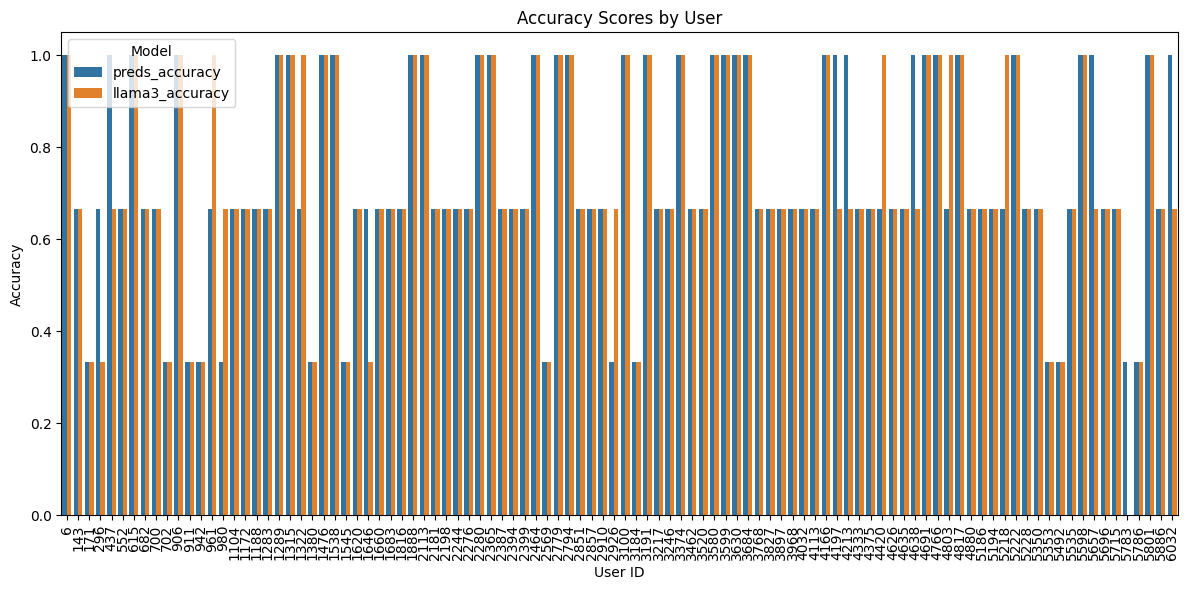

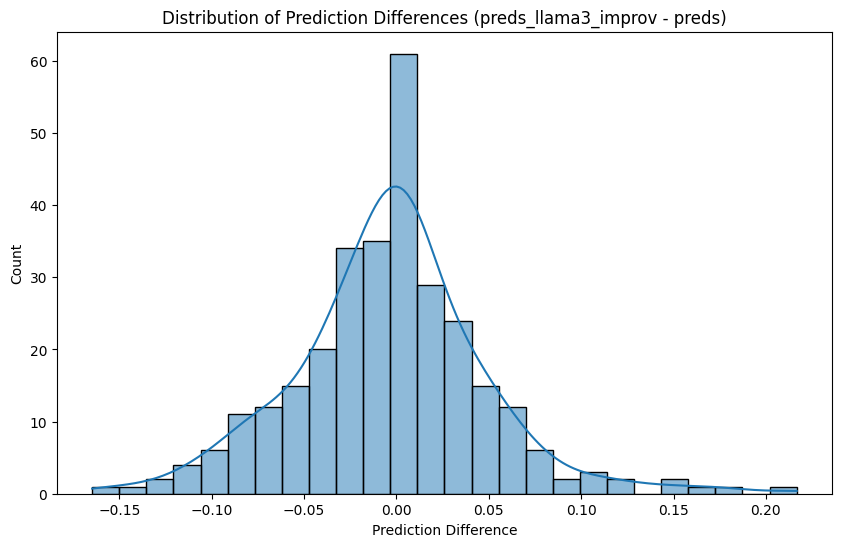


Summary of Prediction Differences:
count    300.000000
mean      -0.003612
std        0.052105
min       -0.164754
25%       -0.030847
50%       -0.000883
75%        0.019355
max        0.216674
Name: pred_diff, dtype: float64


In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_val is already loaded
# Calculate metrics
def calculate_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, np.round(y_pred)),
        'AUC': roc_auc_score(y_true, y_pred),
        'Precision': precision_score(y_true, np.round(y_pred)),
        'Recall': recall_score(y_true, np.round(y_pred)),
        'F1 Score': f1_score(y_true, np.round(y_pred))
    }

metrics_preds = calculate_metrics(df_val['labels'], df_val['preds'])
metrics_llama3 = calculate_metrics(df_val['labels'], df_val['preds_llama3_improv'])

# Print metrics comparison
print("Metrics Comparison:")
print(f"{'Metric':<15}{'preds':<15}{'preds_llama3_improv':<20}")
print("-" * 50)
for metric in metrics_preds.keys():
    print(f"{metric:<15}{metrics_preds[metric]:<15.4f}{metrics_llama3[metric]:<20.4f}")

# Calculate accuracy for each user
user_accuracy = df_val.groupby('user_idx').apply(
    lambda x: pd.Series({
        'preds_accuracy': accuracy_score(x['labels'], np.round(x['preds'])),
        'llama3_accuracy': accuracy_score(x['labels'], np.round(x['preds_llama3_improv']))
    })
).reset_index()

# Plot bar chart of accuracy scores for each user
plt.figure(figsize=(12, 6))
sns.barplot(data=user_accuracy.melt(id_vars='user_idx', var_name='model', value_name='accuracy'),
            x='user_idx', y='accuracy', hue='model')
plt.title('Accuracy Scores by User')
plt.xlabel('User ID')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Additional analysis: distribution of prediction differences
df_val['pred_diff'] = df_val['preds_llama3_improv'] - df_val['preds']

plt.figure(figsize=(10, 6))
sns.histplot(df_val['pred_diff'], kde=True)
plt.title('Distribution of Prediction Differences (preds_llama3_improv - preds)')
plt.xlabel('Prediction Difference')
plt.ylabel('Count')
plt.show()

# Print summary statistics of prediction differences
print("\nSummary of Prediction Differences:")
print(df_val['pred_diff'].describe())

In [19]:
# Display the textual differences between 'user_hist' and 'improved_profile'
for idx, row in df_val.iterrows():
    print(f"User Index: {row['user_idx']}")
    print("Original User History:")
    print(row['user_hist'])
    print("\nImproved Profile:")
    print(row['improved_profile'])
    print("\n" + "-"*80 + "\n")
    break


User Index: 3191
Original User History:
Given a male user who is aged 45-49 and an artist, this user's movie viewing history over time is listed below. Footloose (1984), 3 stars; Ghost (1990), 3 stars; Bone Collector, The (1999), 4 stars; Heat (1995), 5 stars; Scream (1996), 4 stars; Silence of the Lambs, The (1991), 5 stars; North by Northwest (1959), 4 stars; Some Like It Hot (1959), 5 stars; Felicia's Journey (1999), 3 stars; Sleepy Hollow (1999), 4 stars; Faculty, The (1998), 4 stars; Crash (1996), 5 stars; Wild Things (1998), 4 stars; Animal House (1978), 4 stars; Teaching Mrs. Tingle (1999), 4 stars; Interview with the Vampire (1994), 4 stars; Jacob's Ladder (1990), 4 stars; 13th Warrior, The (1999), 3 stars; Astronaut's Wife, The (1999), 3 stars; Misery (1990), 5 stars; Stigmata (1999), 3 stars; Stir of Echoes (1999), 4 stars; Outbreak (1995), 3 stars; American Beauty (1999), 5 stars; Hard Day's Night, A (1964), 3 stars; Everything You Always Wanted to Know About Sex (1972), 3 s

In [17]:
print(df_val['improved_profile'])


0      Given a male user who is aged 45-49 and an art...
1      Given a male user who is aged 45-49 and an art...
2      Given a male user who is aged 45-49 and an art...
3      Given a female user who is aged 18-24 and a ho...
4      Given a female user who is aged 18-24 and a ho...
                             ...                        
295    Given a female user who is aged 35-44 and an e...
296    Given a female user who is aged 35-44 and an e...
297    Given a female user who is aged 35-44 and in a...
298    Given a female user who is aged 35-44 and in a...
299    Given a female user who is aged 35-44 and in a...
Name: improved_profile, Length: 300, dtype: object


In [5]:
# Update df_val['improved_prompt'] based on the same user_idx in train
# Create a temporary dataframe with unique user_idx and improved_profile
df_train_unique = df_train.drop_duplicates(subset='user_idx')[['user_idx', 'improved_profile']]

# Merge df_val with the unique train data
df_val = df_val.merge(df_train_unique, on='user_idx', how='left')

# Rename the merged column to 'improved_prompt'
df_val = df_val.rename(columns={'improved_profile': 'improved_prompt'})

# Display the updated df_val
df_val



,test_index,user_idx,user_key,user_hist,item_idx,item_key,item_desc,user_prompt,item_prompt,improved_prompt
0,0,3191,4496,Given a male user who is aged 45-49 and an art...,3846,3914,The Broken Hearts Club (2000) is a romantic co...,Given a male user who is aged 45-49 and an art...,Introduce movie The Broken Hearts Club (2000) ...,\n As an AI assistant specializing in movie...
1,1,3191,4496,Given a male user who is aged 45-49 and an art...,3833,3903,Urbania is a 2000 American drama film directed...,Given a male user who is aged 45-49 and an art...,Introduce movie Urbania (2000) and describe it...,\n As an AI assistant specializing in movie...
2,2,3191,4496,Given a male user who is aged 45-49 and an art...,3244,3317,Wonder Boys is a 2000 comedy-drama film direct...,Given a male user who is aged 45-49 and an art...,Introduce movie Wonder Boys (2000) and describ...,\n As an AI assistant specializing in movie...
3,3,682,4555,Given a female user who is aged 18-24 and a ho...,1934,2006,The Mask of Zorro is a 1998 American swashbuck...,Given a female user who is aged 18-24 and a ho...,Introduce movie The Mask of Zorro (1998) and d...,\n As an AI assistant specializing in movie...
4,4,682,4555,Given a female user who is aged 18-24 and a ho...,536,539,Sleepless in Seattle is a romantic comedy movi...,Given a female user who is aged 18-24 and a ho...,Introduce movie Sleepless in Seattle (1993) an...,\n As an AI assistant specializing in movie...
...,...,...,...,...,...,...,...,...,...,...
295,295,4420,2677,Given a female user who is aged 35-44 and an e...,523,527,Schindler's List is a historical drama film re...,Given a female user who is aged 35-44 and an e...,Introduce movie Schindler's List (1993) and de...,\n As an AI assistant specializing in movie...
296,296,4420,2677,Given a female user who is aged 35-44 and an e...,535,537,Sirens is a 1994 Australian comedy-drama film ...,Given a female user who is aged 35-44 and an e...,Introduce movie Sirens (1994) and describe its...,\n As an AI assistant specializing in movie...
297,297,2276,285,Given a female user who is aged 35-44 and in a...,48,50,The Usual Suspects is a 1995 neo-noir crime th...,Given a female user who is aged 35-44 and in a...,Introduce movie The Usual Suspects (1995) and ...,\n As an AI assistant specializing in movie...
298,298,2276,285,Given a female user who is aged 35-44 and in a...,369,377,Speed is a 1994 action thriller film directed ...,Given a female user who is aged 35-44 and in a...,Introduce movie Speed (1994) and describe its ...,\n As an AI assistant specializing in movie...


In [5]:
train_set, train_loader, test_set, test_loader = load_datasets(return_df=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/yandex/DL20232024a/asafavrahamy/Projects/RefRec/data/ml-1m/proc_data/bert_avg_augment.hist'

In [3]:
train_set[0]

{'iid': tensor(1602),
 'aid': tensor([13]),
 'lb': tensor(1),
 'hist_iid_seq': tensor([1540,   73,  179,  180,   93]),
 'hist_aid_seq': tensor([[4],
         [5],
         [4],
         [4],
         [4]]),
 'hist_rate_seq': tensor([4, 4, 3, 4, 4]),
 'hist_seq_len': tensor(5),
 'item_aug_vec': tensor([-2.4902e-01,  1.8579e-01,  9.1797e-02, -2.3291e-01,  5.2148e-01,
         -6.6040e-02,  2.5171e-01,  2.7686e-01,  1.8530e-01, -4.9530e-02,
         -1.3635e-01, -1.6382e-01, -2.5940e-02,  6.0303e-01,  1.0291e-01,
          5.9766e-01,  4.2920e-01, -1.4343e-01, -2.8589e-01,  8.1726e-02,
          1.1725e-01, -1.6370e-01, -2.6428e-02,  8.1592e-01,  2.9224e-01,
          4.1626e-01, -2.3169e-01, -1.1328e-01, -2.4097e-01,  1.0919e-01,
          4.3481e-01, -9.5520e-02, -3.3228e-01, -3.0298e-01, -1.2451e-01,
         -8.8562e-02, -8.9233e-02, -2.7051e-01,  3.9093e-02,  1.8457e-01,
         -4.2920e-01, -4.0796e-01,  6.4331e-02, -1.4587e-01,  5.4413e-02,
         -3.2104e-01,  2.7417e-01,  9.86

In [5]:
df_train = pd.read_csv('df_train_all.csv')
df_train['user_idx'].value_counts()

user_idx
4995    1820
1178    1713
1644    1565
3722    1491
1325    1488
        ... 
2881      10
5100      10
5139      10
3959      10
4130      10
Name: count, Length: 5436, dtype: int64

In [ ]:
df_train_user = df_train[df_train['user_idx'] == 5879]
df_train_user

In [2]:
df_train, train_set, train_loader, df_test, test_set, test_loader = load_datasets()

100%|██████████| 92024/92024 [01:02<00:00, 1461.68it/s]


In [16]:
sampled_user_idx = df_train['user_idx'].sample(500, random_state=42)
print(list(sampled_user_idx))


[896, 2215, 3561, 3196, 5827, 2041, 2871, 594, 4709, 3798, 2574, 5796, 2412, 2362, 3685, 1490, 5308, 5835, 5037, 1418, 1065, 2041, 4614, 5276, 5898, 5702, 5342, 4059, 2716, 2460, 3051, 1404, 5147, 3876, 2512, 4510, 1503, 4913, 4242, 3815, 802, 1496, 4695, 5825, 4340, 2155, 3079, 3188, 5060, 2467, 2441, 5017, 4717, 4326, 785, 788, 2140, 4643, 741, 5617, 4586, 3374, 4029, 1476, 4728, 4331, 4511, 1932, 4333, 1804, 3873, 2251, 475, 5673, 100, 2895, 191, 4604, 4924, 5621, 2009, 5962, 483, 1053, 2409, 1162, 3811, 2481, 4481, 2694, 536, 4445, 2372, 1333, 2449, 1705, 1163, 4361, 3125, 1039, 2506, 1563, 203, 5653, 5547, 2024, 5574, 4067, 1702, 1126, 109, 741, 4327, 41, 5230, 1483, 99, 1492, 1667, 3983, 5723, 3327, 1835, 2905, 1042, 5648, 5995, 5090, 59, 4125, 1559, 4620, 3582, 5315, 3658, 2953, 1416, 3517, 1178, 5379, 3050, 2273, 4036, 5695, 3934, 2324, 3022, 2982, 3886, 2034, 1320, 1161, 3398, 1644, 5192, 5229, 1304, 4872, 5021, 5387, 1689, 5428, 211, 5551, 1613, 5955, 4857, 2785, 4259, 3512, 

In [17]:
# Check for overlap in user_idx between train and test datasets
overlap_user_idx = set(df_train['user_idx']).intersection(set(df_test['user_idx']))
print("Overlap User Indices:", overlap_user_idx)

overlap_user_idx = set(df_train['user_key']).intersection(set(df_test['user_key']))
print("Overlap User Indices:", overlap_user_idx)


Overlap User Indices: set()


Overlap User Indices: set()


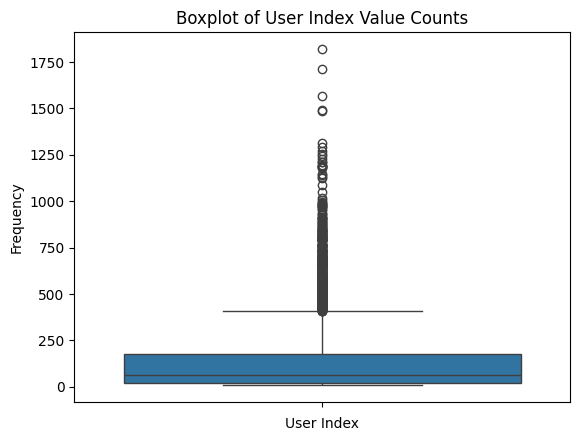

In [13]:
df_train['user_idx'].value_counts()
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the boxplot for 'user_idx' value counts
sns.boxplot(df_train['user_idx'].value_counts())
plt.title('Boxplot of User Index Value Counts')
plt.xlabel('User Index')
plt.ylabel('Frequency')
plt.show()


In [2]:
llm = ChatGroq(temperature=0, model="llama3-70b-8192")

In [3]:
df_train = pd.read_csv('df_train.csv')
df_train.shape

(1460, 12)

In [2]:
df_test = pd.read_csv('df_test.csv')
df_test.head()

,test_index,user_idx,user_key,user_hist,item_idx,item_key,item_desc,user_prompt,item_prompt,labels,preds,new_user_prompt,preds_llama3,preds_llama3_retrain
0,0,1460,1131,"Given a male user who is aged 56+ and retired,...",948,959,Of Human Bondage is a drama film directed by J...,"Given a male user who is aged 56+ and retired,...",Introduce movie Of Human Bondage (1934) and de...,1,0.881885,"Given a male user who is aged 56+ and retired,...",0.869767,0.608741
1,1,1460,1131,"Given a male user who is aged 56+ and retired,...",3181,3246,Malcolm X is a biographical drama film release...,"Given a male user who is aged 56+ and retired,...",Introduce movie Malcolm X (1992) and describe ...,1,0.886062,"Given a male user who is aged 56+ and retired,...",0.875437,0.612334
2,2,1460,1131,"Given a male user who is aged 56+ and retired,...",1602,1649,"Fast, Cheap & Out of Control is a documentary ...","Given a male user who is aged 56+ and retired,...","Introduce movie Fast, Cheap & Out of Control (...",1,0.846270,"Given a male user who is aged 56+ and retired,...",0.833210,0.554016
3,3,1460,1131,"Given a male user who is aged 56+ and retired,...",2542,2612,"""Mildred Pierce"" is a classic film noir drama ...","Given a male user who is aged 56+ and retired,...",Introduce movie Mildred Pierce (1945) and desc...,1,0.915424,"Given a male user who is aged 56+ and retired,...",0.907706,0.617586
4,4,1460,1131,"Given a male user who is aged 56+ and retired,...",3365,3435,Double Indemnity is a classic film noir from 1...,"Given a male user who is aged 56+ and retired,...",Introduce movie Double Indemnity (1944) and de...,1,0.948779,"Given a male user who is aged 56+ and retired,...",0.946313,0.537171


AUC for preds: 0.8376173999011369
AUC for preds_llama3: 0.8235294117647058
AUC for preds_llama3_retrain: 0.6114681166584282


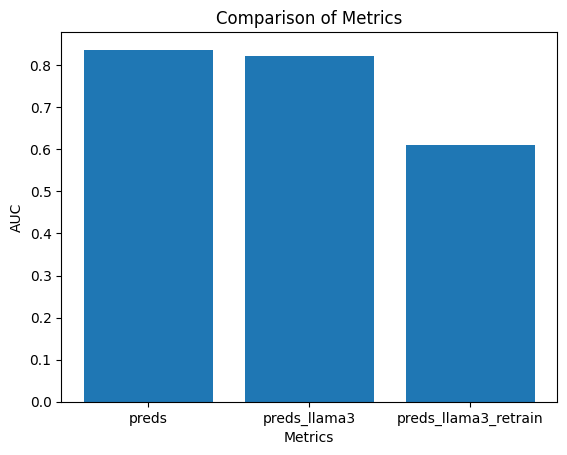

In [4]:
import matplotlib.pyplot as plt

# Create a list of metric names
metrics = ['preds', 'preds_llama3', 'preds_llama3_retrain']
from sklearn.metrics import roc_auc_score

# Calculate AUC for preds
auc_preds = roc_auc_score(df_test['labels'], df_test['preds'])
print(f"AUC for preds: {auc_preds}")

# Calculate AUC for preds_llama3
auc_preds_llama3 = roc_auc_score(df_test['labels'], df_test['preds_llama3'])
print(f"AUC for preds_llama3: {auc_preds_llama3}")

# Calculate AUC for preds_llama3_retrain
auc_preds_llama3_retrain = roc_auc_score(df_test['labels'], df_test['preds_llama3_retrain'])
print(f"AUC for preds_llama3_retrain: {auc_preds_llama3_retrain}")

# Create a list of metric values
values = [auc_preds, auc_preds_llama3, auc_preds_llama3_retrain]

# Plot the bar chart
plt.bar(metrics, values)
plt.xlabel('Metrics')
plt.ylabel('AUC')
plt.title('Comparison of Metrics')
plt.show()

In [15]:
import pandas as pd

# Assuming df_test is already loaded and contains the columns 'labels' and 'preds_llama3_retrain'
df_test['difference'] = (df_test['labels'] - df_test['preds_llama3_retrain']).abs()

# Filter to focus on large differences
threshold = 0.5  # Define a threshold for 'big differences'
significant_diffs = df_test[df_test['difference'] > threshold]

# Create a dictionary to accumulate prompts for each user_idx
user_prompts = {}

for index, row in significant_diffs.iterrows():
    user_idx = row['user_idx']
    if user_idx not in user_prompts:
        user_prompts[user_idx] = "Reflect on the following cases where there were significant discrepancies between the actual labels and the predictions for your user index:\n"
    user_prompts[user_idx] += f"- The actual label was {row['labels']:.2f} while the predicted probability was {row['preds_llama3_retrain']:.2f}. The difference of {row['difference']:.2f} indicates a significant prediction error.\n"

# Example of how to use these prompts with the llm
for user_idx, prompt in user_prompts.items():
    print(f"Prompt for user_idx {user_idx}:\n{prompt}\n")
    # Assuming llm is an instance of ChatGroq
    response = llm.invoke(prompt)
    print(f"Response for user_idx {user_idx}:\n{response}\n")
    break

Prompt for user_idx 1460:
Reflect on the following cases where there were significant discrepancies between the actual labels and the predictions for your user index:
- The actual label was 1.00 while the predicted probability was 0.48. The difference of 0.52 indicates a significant prediction error.
- The actual label was 1.00 while the predicted probability was 0.48. The difference of 0.52 indicates a significant prediction error.
- The actual label was 1.00 while the predicted probability was 0.47. The difference of 0.53 indicates a significant prediction error.
- The actual label was 1.00 while the predicted probability was 0.49. The difference of 0.51 indicates a significant prediction error.
- The actual label was 1.00 while the predicted probability was 0.48. The difference of 0.52 indicates a significant prediction error.
- The actual label was 0.00 while the predicted probability was 0.52. The difference of 0.52 indicates a significant prediction error.
- The actual label was 

In [3]:
# Prompt 
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

In [4]:
llm.invoke(system)



AIMessage(content="I'm ready to help. What's your question?", response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 60, 'total_tokens': 71, 'completion_time': 0.030259761, 'prompt_time': 0.012266699, 'queue_time': None, 'total_time': 0.04252646}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2f30b0b571', 'finish_reason': 'stop', 'logprobs': None}, id='run-df380f3a-8f21-4332-9d9b-d04f4cd6c2dd-0')

,test_index,user_idx,user_key,user_hist,item_idx,item_key,item_desc,user_prompt,item_prompt,labels,preds,new_user_prompt,preds_llama3,preds_llama3_retrain
0,0,1460,1131,"Given a male user who is aged 56+ and retired,...",948,959,Of Human Bondage is a drama film directed by J...,"Given a male user who is aged 56+ and retired,...",Introduce movie Of Human Bondage (1934) and de...,1,0.881885,"Given a male user who is aged 56+ and retired,...",0.869767,0.606020
1,1,1460,1131,"Given a male user who is aged 56+ and retired,...",3181,3246,Malcolm X is a biographical drama film release...,"Given a male user who is aged 56+ and retired,...",Introduce movie Malcolm X (1992) and describe ...,1,0.886062,"Given a male user who is aged 56+ and retired,...",0.875437,0.600829
2,2,1460,1131,"Given a male user who is aged 56+ and retired,...",1602,1649,"Fast, Cheap & Out of Control is a documentary ...","Given a male user who is aged 56+ and retired,...","Introduce movie Fast, Cheap & Out of Control (...",1,0.846270,"Given a male user who is aged 56+ and retired,...",0.833210,0.507870
3,3,1460,1131,"Given a male user who is aged 56+ and retired,...",2542,2612,"""Mildred Pierce"" is a classic film noir drama ...","Given a male user who is aged 56+ and retired,...",Introduce movie Mildred Pierce (1945) and desc...,1,0.915424,"Given a male user who is aged 56+ and retired,...",0.907706,0.584807
4,4,1460,1131,"Given a male user who is aged 56+ and retired,...",3365,3435,Double Indemnity is a classic film noir from 1...,"Given a male user who is aged 56+ and retired,...",Introduce movie Double Indemnity (1944) and de...,1,0.948779,"Given a male user who is aged 56+ and retired,...",0.946313,0.580385


In [5]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Calculate AUC for preds
auc_preds = roc_auc_score(df_test['labels'], df_test['preds'])
print(f"AUC for preds: {auc_preds}")

# Calculate accuracy for preds
accuracy_preds = accuracy_score(df_test['labels'], df_test['preds'].round())
print(f"Accuracy for preds: {accuracy_preds}")

# Calculate AUC for preds_llama3
auc_preds_llama3 = roc_auc_score(df_test['labels'], df_test['preds_llama3'])
print(f"AUC for preds_llama3: {auc_preds_llama3}")

# Calculate accuracy for preds_llama3
accuracy_preds_llama3 = accuracy_score(df_test['labels'], df_test['preds_llama3'].round())
print(f"Accuracy for preds_llama3: {accuracy_preds_llama3}")

# Calculate AUC for preds_llama3_retrain
auc_preds_llama3_retrain = roc_auc_score(df_test['labels'], df_test['preds_llama3_retrain'])
print(f"AUC for preds_llama3_retrain: {auc_preds_llama3_retrain}")

# Calculate accuracy for preds_llama3_retrain
accuracy_preds_llama3_retrain = accuracy_score(df_test['labels'], df_test['preds_llama3_retrain'].round())
print(f"Accuracy for preds_llama3_retrain: {accuracy_preds_llama3_retrain}")


AUC for preds: 0.8376173999011369
Accuracy for preds: 0.803921568627451
AUC for preds_llama3: 0.8235294117647058
Accuracy for preds_llama3: 0.8104575163398693
AUC for preds_llama3_retrain: 0.7434503213049926
Accuracy for preds_llama3_retrain: 0.738562091503268
